## Coronavirus Tweets Classification
**My goal for this notebook is to do text data analysis, process the text and then use machine learning to classify whether the tweets about COVID-19 convey positive, negative or neutral message (multi-class classification problem).**

In [51]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

# Text processing
import re
import string
import nltk
from nltk.corpus import stopwords

# Machine learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [52]:
train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [53]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [54]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [56]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


**Location values are missing from both datasets but it doesn't matter since it's not an important feature for tweet classification.**

In [57]:
train.isnull().sum().sort_values(ascending=False)

Location         8590
Sentiment           0
OriginalTweet       0
TweetAt             0
ScreenName          0
UserName            0
dtype: int64

In [58]:
test.isnull().sum().sort_values(ascending=False)

Location         834
Sentiment          0
OriginalTweet      0
TweetAt            0
ScreenName         0
UserName           0
dtype: int64

**Changing the type from object to string helps with text processing.**

In [59]:
train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

**Shape of our datasets (rows, columns)**

In [60]:
print('Training Set Shape = {}'.format(train.shape))
print('Testing Set Shape = {}'.format(test.shape))

Training Set Shape = (41157, 6)
Testing Set Shape = (3798, 6)


**Getting sentiments from 5 to 3 possible values is going to make it easier for an algorithm to classify the tweets. Also, for this notebook, we don't care for extremely positive/negative sentiments, just whether the tweet is sending a positive, negative or neutral message about coronavirus.**

In [61]:
def sentiment_change(x):
    if x ==  "Extremely Positive" or x == "Positive":
        return "Positive"
    elif x == "Extremely Negative" or x == "Negative":
        return "Negative"
    else:
        return "Neutral"

In [62]:
train['Sentiment']=train['Sentiment'].apply(lambda x:sentiment_change(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:sentiment_change(x))

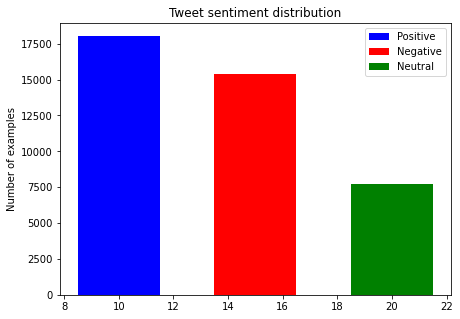

In [63]:
positive_len = train[train['Sentiment'] == "Positive"].shape[0]
negative_len = train[train['Sentiment'] == "Negative"].shape[0]
neutral_len = train[train['Sentiment'] == "Neutral"].shape[0]

plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,positive_len, 3, label="Positive", color='blue')
plt.bar(15,negative_len,3, label="Negative", color='red')
plt.bar(20,neutral_len,3, label="Neutral", color='green')

plt.legend()

plt.ylabel('Number of examples')
plt.title('Tweet sentiment distribution')
plt.show()

**Number of characters in positive and negative tweets are similarly distributed where most tweets are 250-280 characters long. Number of characters in neutral tweets are more evenly distributed with most tweets being 120-140 characters long.**

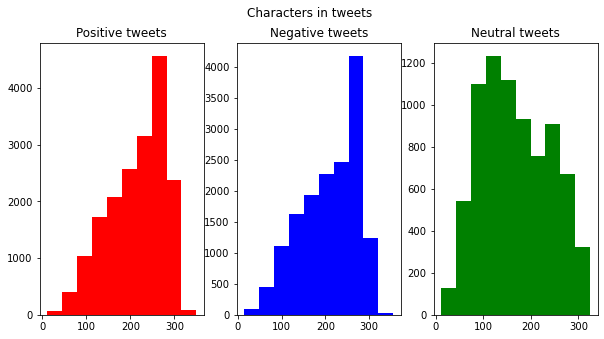

In [64]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))

tweet_len=train[train['Sentiment']=='Positive']['OriginalTweet'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Positive tweets')

tweet_len=train[train['Sentiment']=='Negative']['OriginalTweet'].str.len()
ax2.hist(tweet_len,color='blue')
ax2.set_title('Negative tweets')

tweet_len=train[train['Sentiment']=='Neutral']['OriginalTweet'].str.len()
ax3.hist(tweet_len,color='green')
ax3.set_title('Neutral tweets')

fig.suptitle('Characters in tweets')
plt.show()

**Same analogy goes for number of words. It makes sense that neutral sentiment tweets would need fewer characters/words to express their neutrality.**

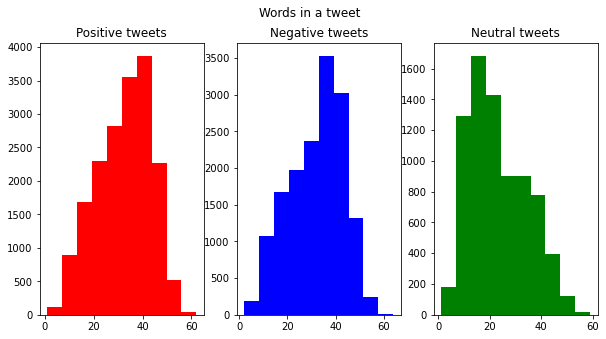

In [65]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
tweet_len=train[train['Sentiment']=='Positive']['OriginalTweet'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Positive tweets')

tweet_len=train[train['Sentiment']=='Negative']['OriginalTweet'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='blue')
ax2.set_title('Negative tweets')

tweet_len=train[train['Sentiment']=='Neutral']['OriginalTweet'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='green')
ax3.set_title('Neutral tweets')

fig.suptitle('Words in a tweet')
plt.show()

**All we need for tweet classification are the tweet texts and their sentiment. We can drop the other columns.**

In [66]:
train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace=True)
test.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1, inplace=True)

train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


**We can use wordcloud to visualize the most frequent words used in both positive and negative tweets. Most of the tweets contain URLs which is why 'https' is shown as one of the most frequent words. We're going to clean the text later and use wordcloud again to get the more accurate representation.**

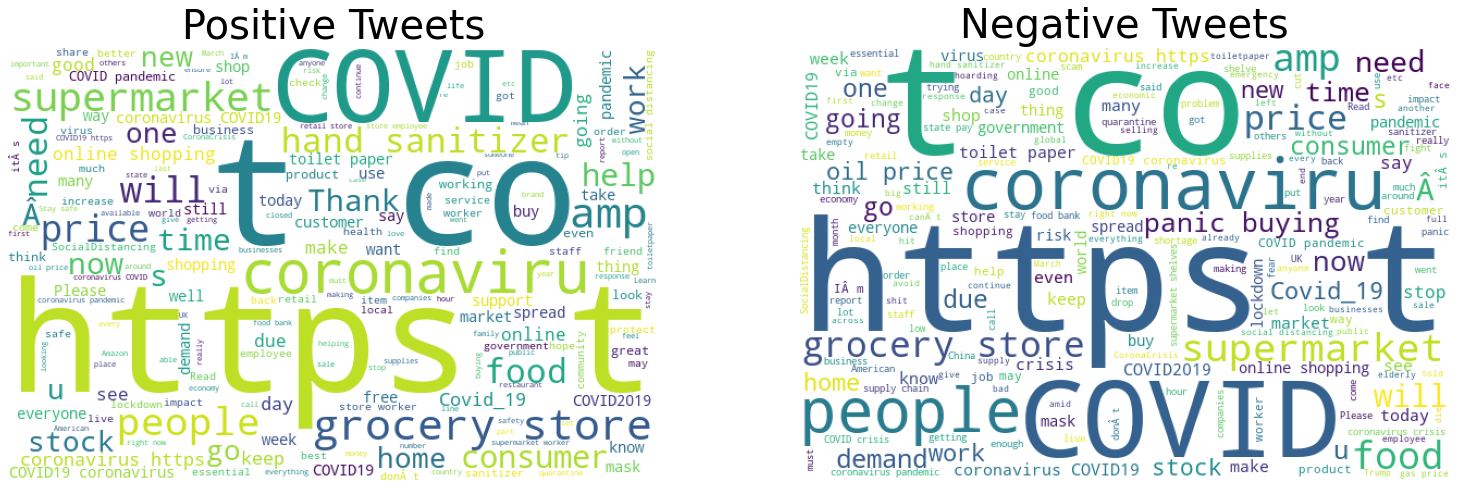

In [67]:
positive_tweets = train[train['Sentiment']=='Positive']['OriginalTweet']
negative_tweets = train[train['Sentiment']=='Negative']['OriginalTweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Tweets',fontsize=40);

## Data cleaning
**We'll make text lowercase and then clean it from links, brackets, emojis, stopwords, etc.**

In [68]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'',text)
    
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    
    return text

stop_words = stopwords.words('english')
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train['OriginalTweet'] = train['OriginalTweet'].apply(clean_text)
train['OriginalTweet'].head()

0                          menyrbie philgahan chrisitv
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock empty please dont panic enough food...
4    ready supermarket outbreak paranoid food stock...
Name: OriginalTweet, dtype: object

**Let's use wordcloud on the clean tweets now.**

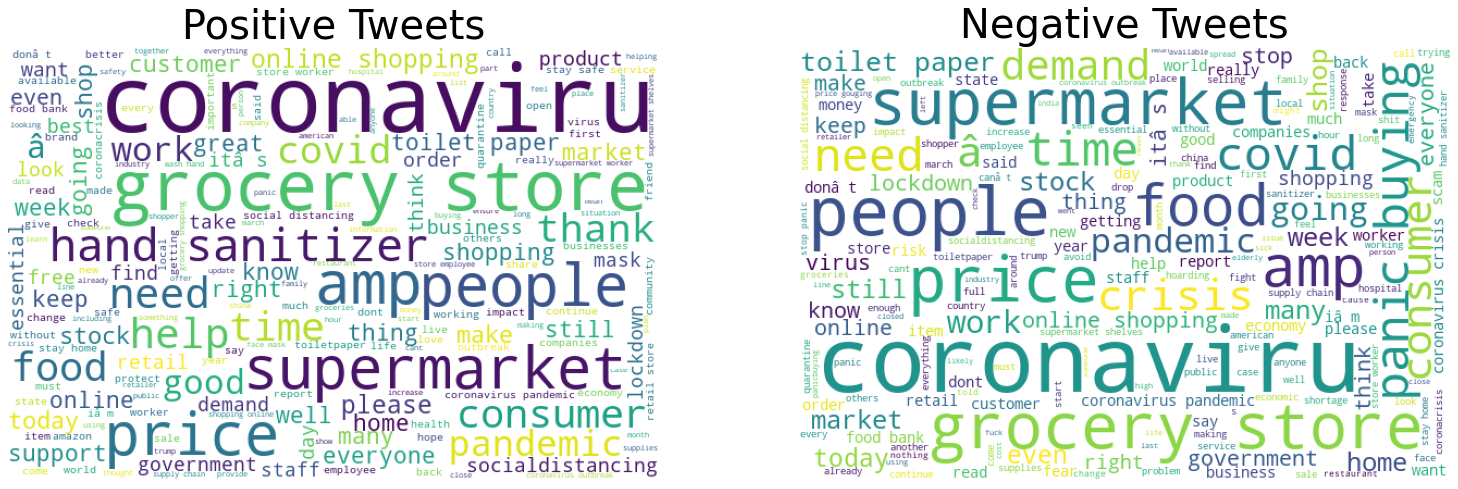

In [69]:
positive_tweets = train[train['Sentiment']=='Positive']['OriginalTweet']
negative_tweets = train[train['Sentiment']=='Negative']['OriginalTweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Tweets',fontsize=40);

## Modelling
**It is important to tokenize the text first. Tokenization is a process that splits a sentence into tokens where token can be a word, sentence, etc. After performing tokenization, we will pad each sentence to the maximum length there is in our batch.**

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['OriginalTweet'])

X = tokenizer.texts_to_sequences(train['OriginalTweet'])

vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
X = pad_sequences(X, padding='post')

Vocabulary size: 56470


**Let's encode the sentiment column**

In [71]:
encoding = {
            'Negative': 0,
            'Neutral': 1,
            'Positive':2
           }

labels = ['Negative', 'Neutral', 'Positive']
           
y=train['Sentiment'].copy()
y.replace(encoding, inplace=True)

**For modelling, I will use a sequential neural network with LSTM (Long Short Term Memory) layer. LSTM enables our model to learn what information to store in long term memory and what to get rid of. LSTM has a special architecture which enables it to forget the unnecessary information.**

In [72]:
tf.keras.backend.clear_session()

EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    Layers.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    Layers.Bidirectional(Layers.LSTM(units,return_sequences=True)),
    Layers.GlobalMaxPool1D(),
    Layers.Dropout(0.4),
    Layers.Dense(64, activation="relu"),
    Layers.Dropout(0.4),
    Layers.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 16)            903520    
_________________________________________________________________
bidirectional (Bidirectional (None, 36, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [73]:
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/2
1132/1132 [==============================] - 173s 153ms/step - loss: 0.7219 - accuracy: 0.6840 - val_loss: 0.4896 - val_accuracy: 0.8313
Epoch 2/2
1132/1132 [==============================] - 209s 185ms/step - loss: 0.3964 - accuracy: 0.8684 - val_loss: 0.5026 - val_accuracy: 0.8234


**We can plot the accuracy and loss achieved during training.**

In [74]:
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

In [75]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

## Prediction on test data

In [76]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(clean_text)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(encoding, inplace=True)

In [77]:
pred = np.argmax(model.predict(X_test), axis=-1)

pred

array([0, 2, 2, ..., 1, 0, 2])

In [78]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.5447653532028198
Test Accuracy: 0.7993680834770203


**Confusion matrix shows us how many negative tweets were classified as negative, how many as neutral and how many of them as positive. It does the same for other two sentiments.**

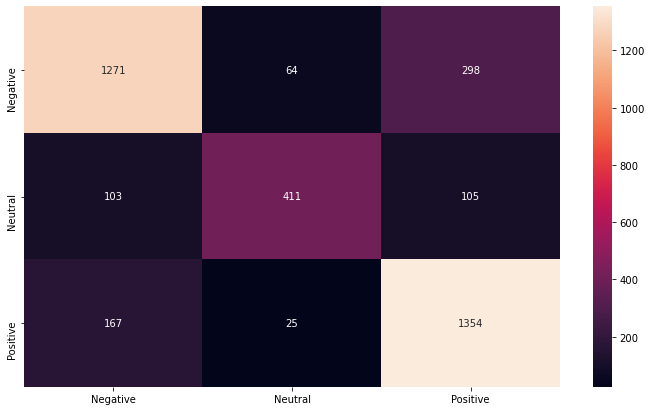

In [79]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

**Precision is defined as the ratio of the total number of correctly classified positive classes divided by the total number of predicted positive classes. Recall is defined as the ratio of the total number of correctly classified positive classes divide by the total number of positive classes. F (or F1) score balances precision and recall by finding their harmonic mean.**

In [80]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.82      0.78      0.80      1633
     Neutral       0.82      0.66      0.73       619
    Positive       0.77      0.88      0.82      1546

    accuracy                           0.80      3798
   macro avg       0.81      0.77      0.79      3798
weighted avg       0.80      0.80      0.80      3798

